# Spatial statistics: from global to local and univariate to multivariate

In [1]:
!pip install cenpy
!pip install python-Levenshtein

## Exercise 1: imports (2 points) 
<div class="alert alert-block alert-success">
       Exercise 1: There are eight instances of 'xxx' below in the second code block of import statements. Replace each instance with the keywords for the appropriate modules, submodules, classes or functions. You should be able to run the entire cell of code without any errors. The comments on each line provide additional clues as to what needs to be imported. Hint: You can find examples for each throughout the demonstration notebooks.

</div>

In [2]:
#Foundational libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import geopandas as gp
import cenpy as cen
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

#Needed for spatial statistics
import libpysal.weights as sw #spatial weights
from esda.moran import Moran, Moran_Local #global & local Moran's I
import spreg #spatial regression module
from mgwr.gwr import GWR, MGWR #GWR & MGWR constructors
from mgwr.sel_bw import Sel_BW #bandwidth selection constructor
from mgwr.utils import compare_surfaces, truncate_colormap, shift_colormap
from splot.esda import lisa_cluster, plot_local_autocorrelation

## Exercise 2: Loading and preparing data (6 points) 


In [3]:
fname = 'crude_16.csv'
obesity = pd.read_csv(fname, encoding='latin1', header=2)

In [4]:
obesity.head()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
0,Autauga County,Alabama,1001.0,33.3,27.5,39.5
1,Baldwin County,Alabama,1003.0,31,28.2,34
2,Barbour County,Alabama,1005.0,41.7,34.5,49.2
3,Bibb County,Alabama,1007.0,37.6,30.1,46
4,Blount County,Alabama,1009.0,33.8,28.2,39.9


In [5]:
obesity.tail()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
3222,Teton County,Wyoming,56039.0,12.4,9.8,15.5
3223,Uinta County,Wyoming,56041.0,35.8,30.6,40.4
3224,Washakie County,Wyoming,56043.0,28.8,23.4,34.8
3225,Weston County,Wyoming,56045.0,33.3,28,39.1
3226,US Diabetes Surveillance System; www.cdc.gov/d...,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-success">
       Exercise 2.1: Drop The last row of the obesity dataframe that has the 'NaN' values. You should be able to check the tail of the obesity dataframe afterward and see the row is removed.

</div>

In [6]:
# drop the NaN values and reassign the results to the obesity variable
obesity.drop(obesity.tail(1).index,inplace=True)

In [7]:
obesity.tail()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
3221,Sweetwater County,Wyoming,56037.0,29.8,26.2,33.3
3222,Teton County,Wyoming,56039.0,12.4,9.8,15.5
3223,Uinta County,Wyoming,56041.0,35.8,30.6,40.4
3224,Washakie County,Wyoming,56043.0,28.8,23.4,34.8
3225,Weston County,Wyoming,56045.0,33.3,28,39.1


<div class="alert alert-block alert-success">
       Exercise 2.2: Convert the 'CountyFIPS' column from float to integer to remove the decimal and then convert from integer to a string.

</div>

In [8]:
# convert 'CountyFIPS
obesity["CountyFIPS"] = obesity["CountyFIPS"].astype(int)
obesity["CountyFIPS"] = obesity["CountyFIPS"].astype(str)

In [9]:
obesity.head()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
0,Autauga County,Alabama,1001,33.3,27.5,39.5
1,Baldwin County,Alabama,1003,31,28.2,34
2,Barbour County,Alabama,1005,41.7,34.5,49.2
3,Bibb County,Alabama,1007,37.6,30.1,46
4,Blount County,Alabama,1009,33.8,28.2,39.9


<div class="alert alert-block alert-success">
       Exercise 2.3: We'll use cenpy to collect variables from the 2016 american community survey (5-year estimates). Then create a 'CountyFIPS' column in the data dataframe by combining the 'state' and 'county' columns. In order to match the obesity dataframe, convert the 'state' column to first to an integer and then to a string before concatenating with 'county' converted to a string. Finally, merge the obesity and data dataframes on the 'CountyFIPS' column and reassign the results to the obesity variable. 

</div>

In [10]:
# establish connection
con = cen.remote.APIConnection('ACSDT5Y2016')
con

Connection to ACS 5-Year Detailed Tables (ID: https://api.census.gov/data/id/ACSDT5Y2016)

In [11]:
#variable definitions

# B25099_001E = median household income 
# B16010_041E = total population w/ bachelor degree or higher
# B22005B_002E = individuals enrolled in Supplemental Nutrition Assistance Program (SNAP) within last 12 months
# B03002_012E = total population identifying as Hispanic
# C27001G_007E = individuals 18-64 w/o health insurance
# B25026_001E = total population

cols = ['B25099_001E', 'B16010_041E', 'B22005B_002E', 'B03002_012E', 'C27001G_007E', 'B25026_001E']
cols

['B25099_001E',
 'B16010_041E',
 'B22005B_002E',
 'B03002_012E',
 'C27001G_007E',
 'B25026_001E']

In [12]:
# make query

data = con.query(cols, geo_unit='county')

In [13]:
data.head()

,B25099_001E,B16010_041E,B22005B_002E,B03002_012E,C27001G_007E,B25026_001E,state,county
0,39125,1390,0,304,62,18178,29,229
1,77330,49705,1231,15082,543,230398,29,047
2,43911,1372,0,235,41,15365,29,065
3,48929,2851,181,2201,24,21836,29,195
4,51274,260,0,33,14,2004,29,227


In [14]:
# create 'CountyFIPS' column in data dataframe
data["state"] = data["state"].astype(str)
data["CountyFIPS"] = data.state + data.county

In [15]:
# merge obesity and data dataframes on 'CountyFIPS'
obesity = obesity.merge(data, left_on = 'CountyFIPS', right_on = 'CountyFIPS')

In [16]:
obesity.tail()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit,B25099_001E,B16010_041E,B22005B_002E,B03002_012E,C27001G_007E,B25026_001E,state,county
2899,Sweetwater County,Wyoming,56037,29.8,26.2,33.3,80794,6071,8,7107,263,44164,56,037
2900,Teton County,Wyoming,56039,12.4,9.8,15.5,98350,9101,0,3433,1,21790,56,039
2901,Uinta County,Wyoming,56041,35.8,30.6,40.4,63329,2374,0,1872,11,20649,56,041
2902,Washakie County,Wyoming,56043,28.8,23.4,34.8,57234,1230,0,1166,66,8175,56,043
2903,Weston County,Wyoming,56045,33.3,28,39.1,61500,974,0,72,0,6819,56,045


<div class="alert alert-block alert-success">
       Exercise 2.4: Read in the counties.geojson file countaining county boundary geometries. Then create a 'CountyFIPS' column as was done above using the 'STATE' and 'COUNTY' columns in the countries dataframe. Finally, merge the obesity dataframe into the counties dataframe, remove Hawaii, Alaska, and Puerto Rico, and plot the continental states. 

</div>

In [17]:
#This is how county geom was originally obtained - takes a good 10/15 min
#con.set_mapservice('tigerWMS_ACS2016')
#geodata = con.mapservice.query(layer=84, where='OID > 0')
#geodata.to_file('counties.shp')

# read in counties boundary file
counties = gp.read_file('zip://counties.zip')

In [18]:
# create 'CountyFIPS' column
counties["CountyFIPS"] = counties.STATE + counties.COUNTY

In [19]:
counties.head()

,MTFCC,OID,GEOID,STATE,COUNTY,COUNTYNS,BASENAME,NAME,LSADC,FUNCSTAT,COUNTYCC,AREALAND,AREAWATER,OBJECTID,CENTLAT,CENTLON,INTPTLAT,INTPTLON,geometry,CountyFIPS
0,G4020,27556109873712,30015,30,015,01719619,Chouteau,Chouteau County,06,A,H1,10288778621,62611691,1,+47.8806543,-110.4354426,+47.8868343,-110.4362004,"POLYGON ((-12315494.121 6143488.405, -12315265...",30015
1,G4020,27556119101045,31017,31,017,00835830,Brown,Brown County,06,A,H1,3163296263,9814399,2,+42.4294932,-099.9293903,+42.3595618,-099.9239198,"POLYGON ((-11111319.574 5272855.550, -11111155...",31017
2,G4020,27556136791559,47013,47,013,01639728,Campbell,Campbell County,06,A,H1,1243685301,46425148,3,+36.4034350,-084.1494562,+36.4015922,-084.1592495,"POLYGON ((-9386705.591 4354814.516, -9386736.2...",47013
3,G4020,27556177452845,37069,37,069,01008553,Franklin,Franklin County,06,A,H1,1273761672,7173998,4,+36.0827221,-078.2857435,+36.0882406,-078.2830903,"POLYGON ((-8728718.456 4324164.707, -8728364.7...",37069
4,G4020,27556165683114,24510,24,510,01702381,Baltimore,Baltimore city,25,F,C7,209649356,28758714,5,+39.3009639,-076.6106288,+39.3000324,-076.6104761,"POLYGON ((-8539486.120 4774265.314, -8539486.0...",24510


In [20]:
# merge the obesity dataframe into the counties dataframe
counties = counties.merge(obesity, left_on = 'CountyFIPS', right_on = 'CountyFIPS')

In [21]:
counties.head()

,MTFCC,OID,GEOID,STATE,COUNTY,COUNTYNS,BASENAME,NAME,LSADC,FUNCSTAT,...,Lower Limit,Upper Limit,B25099_001E,B16010_041E,B22005B_002E,B03002_012E,C27001G_007E,B25026_001E,state,county
0,G4020,27556109873712,30015,30,015,01719619,Chouteau,Chouteau County,06,A,...,22.4,36.5,49899,963,0,124,13,5729,30,015
1,G4020,27556119101045,31017,31,017,00835830,Brown,Brown County,06,A,...,32,45.3,44737,428,0,31,6,2972,31,017
2,G4020,27556136791559,47013,47,013,01639728,Campbell,Campbell County,06,A,...,25.1,41.1,40758,3041,16,484,55,39488,47,013
3,G4020,27556177452845,37069,37,069,01008553,Franklin,Franklin County,06,A,...,27.1,45.8,52626,8805,1947,4969,102,61328,37,069
4,G4020,27556165683114,24510,24,510,01702381,Baltimore,Baltimore city,25,F,...,32.8,37.1,63187,125423,52203,29537,823,596742,24,510


<AxesSubplot:>

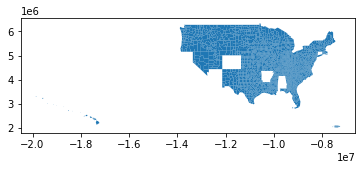

In [22]:
counties.plot()

In [23]:
# remove Hawaii, Alaska, and Puerto Rico
no_AK = (counties['State'] != 'Alaska') 
no_HI = (counties['State'] != 'Hawaii') 
no_PR = (counties['State'] != 'Puerto Rico')
counties = counties[no_AK & no_HI & no_PR]

<AxesSubplot:>

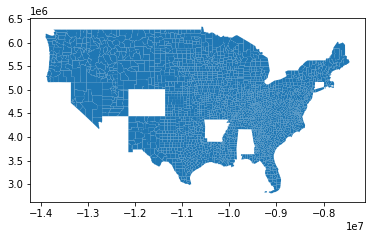

In [24]:
counties.plot()

## Exercise 3: Mapping and exploratory spatial data analysis (4 points)

In [25]:
# convert explanatory variables to percentages
counties['B16010_041E'] = counties['B16010_041E'].astype(float) / counties['B25026_001E'].astype(float)
counties['B22005B_002E'] = counties['B22005B_002E'].astype(float) / counties['B25026_001E'].astype(float)
counties['B03002_012E'] = counties['B03002_012E'].astype(float) / counties['B25026_001E'].astype(float)
counties['C27001G_007E'] = counties['C27001G_007E'].astype(float) / counties['B25026_001E'].astype(float)

<AxesSubplot:>

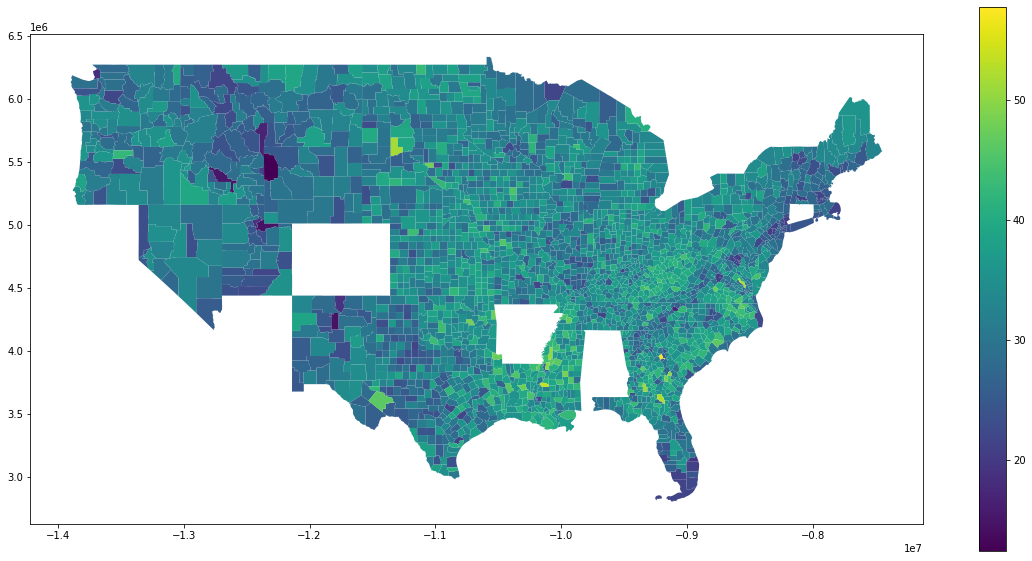

In [26]:
# plot obesity percentages (dependent variable)
counties['Percentage'] = counties['Percentage'].astype(float)
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('Percentage', legend=True, ax=ax)

<AxesSubplot:>

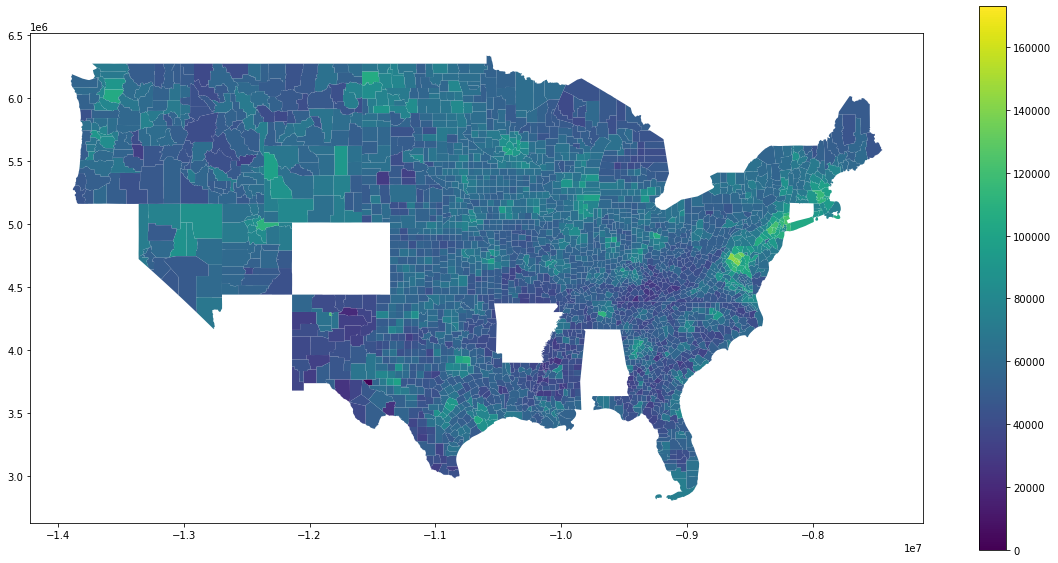

In [27]:
# plot median income
counties['B25099_001E'] = counties['B25099_001E'].astype(float)
counties.loc[(counties['B25099_001E'] < 0), 'B25099_001E' ] = 0
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('B25099_001E', legend=True, ax=ax)

<AxesSubplot:>

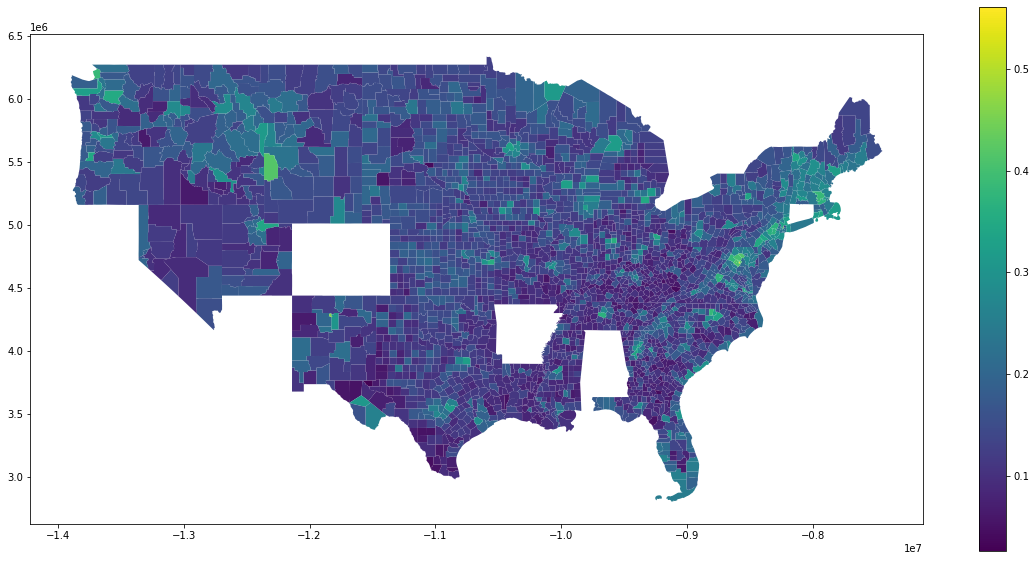

In [28]:
# plot percent w/ bachelor+
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('B16010_041E', legend=True, ax=ax)

<AxesSubplot:>

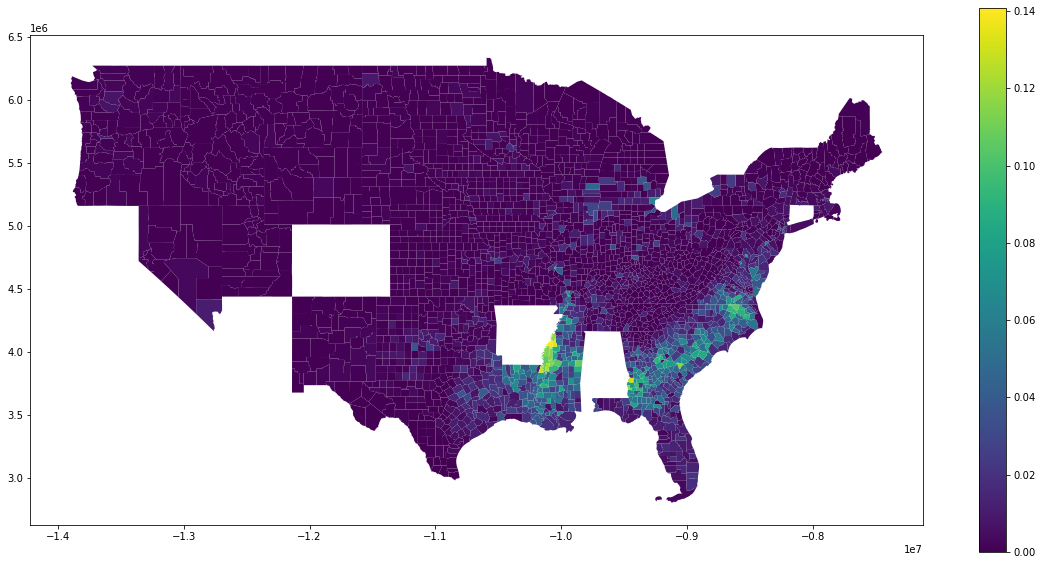

In [29]:
# plot percent SNAP
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('B22005B_002E', legend=True, ax=ax)

<AxesSubplot:>

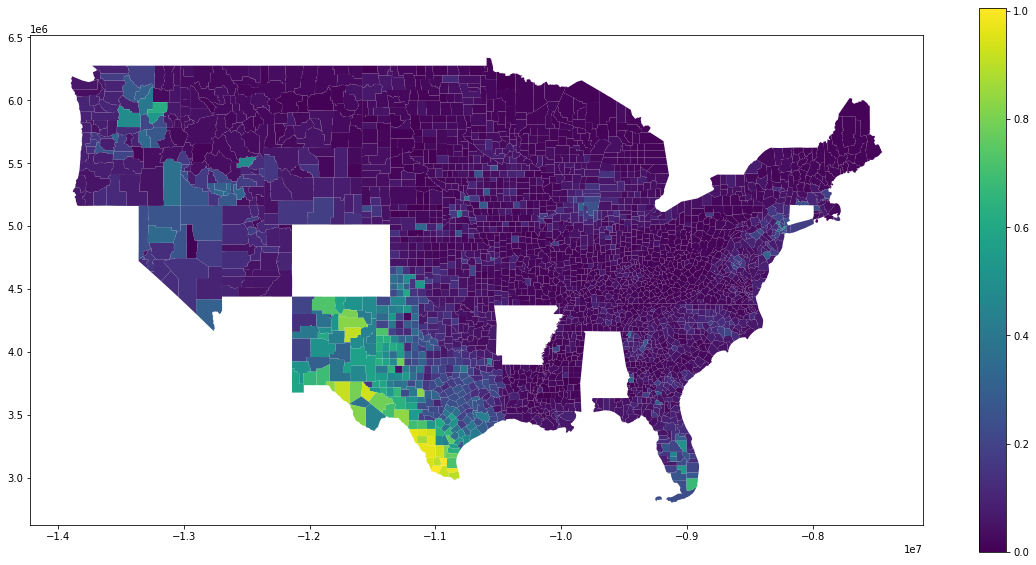

In [30]:
# plot percent hispanic
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('B03002_012E', legend=True, ax=ax)

<AxesSubplot:>

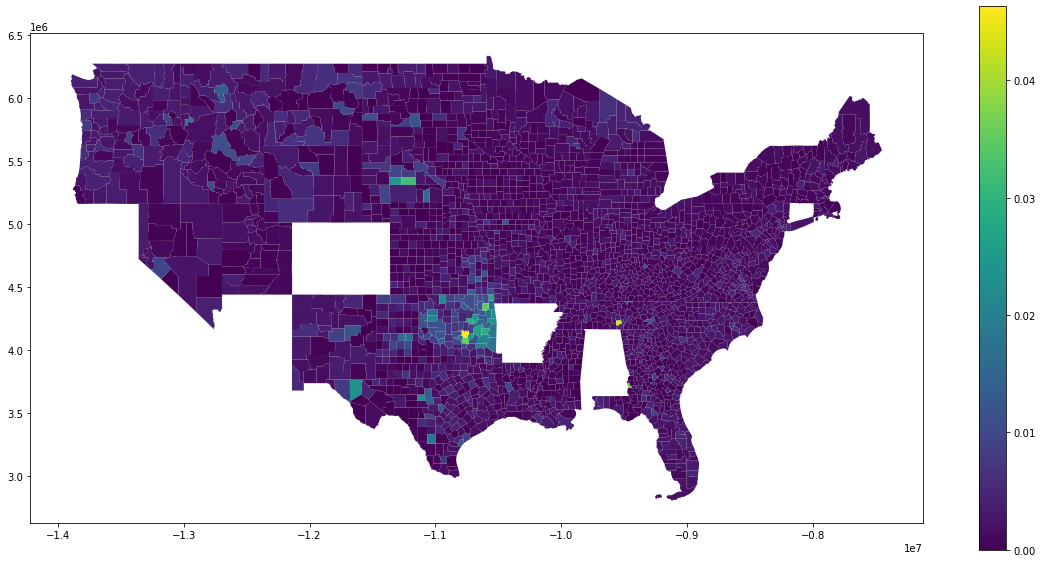

In [31]:
# plot percent no insurance
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('C27001G_007E', legend=True, ax=ax)

In [32]:
# check collinearity using oairwise Pearson's correlation coefficient
counties[cols[:-1]].corr()

,B25099_001E,B16010_041E,B22005B_002E,B03002_012E,C27001G_007E
B25099_001E,1.000000,0.754114,-0.207436,0.016483,-0.065583
B16010_041E,0.754114,1.000000,-0.123159,-0.061930,-0.023559
B22005B_002E,-0.207436,-0.123159,1.000000,-0.085298,-0.029084
B03002_012E,0.016483,-0.061930,-0.085298,1.000000,0.106215
C27001G_007E,-0.065583,-0.023559,-0.029084,0.106215,1.000000


<div class="alert alert-block alert-success">
       Exercise 3.1: There is moderate-to-high collinearity (r=0.75) between income (B25099_001E) and education (B16010_041E), so we will not include the income variable moving forward, since they largely contain similar information. Next, create a Queen contiguity-based spatial weight matrix for the counties and assign it to a variable named 'w'. Use spatial weight matrix to compute Moran's I for percent obesity and each of the remaining explanatory variables. Do all of the surfaces have stasticically significant positive spatial autocorrelation?

</div>

In [33]:
# create Queen spatial weight matrix
w = sw.Queen.from_dataframe(counties)

In [34]:
# Morans I for percent obesity
m_obesity = Moran(counties['Percentage'], w)
print(m_obesity.I, m_obesity.p_sim)

0.3201420119891 0.001


In [35]:
# Morans I for education
m_education = Moran(counties['B16010_041E'], w)
print(m_education.I, m_education.p_sim)

0.4476049397900987 0.001


In [36]:
# Morans I for SNAP
m_SNAP = Moran(counties['B22005B_002E'], w)
print(m_SNAP.I, m_SNAP.p_sim)

0.72604742795869 0.001


In [37]:
# Morans I for hispanic
m_hispanic = Moran(counties['B03002_012E'], w)
print(m_hispanic.I, m_hispanic.p_sim)

0.809508447659045 0.001


In [38]:
# Morans I for no insurance
m_insurance_null = Moran(counties['C27001G_007E'], w)
print(m_insurance_null.I, m_insurance_null.p_sim)

0.40632010123248957 0.001


<div class="alert alert-block alert-success">
       Exercise 3.2: Compute local Moran's I for percent obesity and plot the hot spots and cold spots on a single map. Where are the cold spots the most prominent and where are the hotspots the most prominent?
</div>

In [39]:
# compute local Moran's I for percent obesity
lm = Moran_Local(counties['Percentage'], w, transformation = "r", permutations = 99)

In [40]:
sig = lm.p_sim < 0.05
hotspot = sig * lm.q==1
coldspot = sig * lm.q==3

In [41]:
spot_h = ['n.sig.', 'hot spot']
label_h = [spot_h[i] for i in hotspot*1]

spot_c = ['n.sig.', 'cold spot']
label_c = [spot_c[i] for i in coldspot*1]

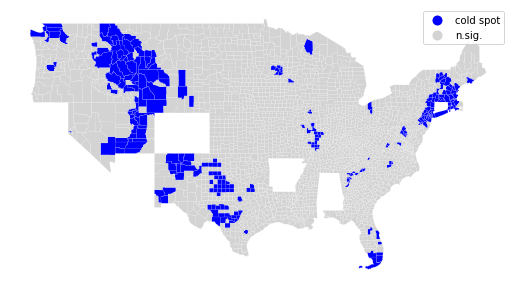

In [42]:
# plot hot spots and cold spots
counties = counties
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
counties.assign(cl=label_c).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

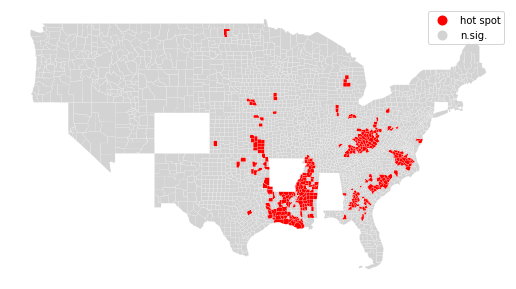

In [43]:
counties = counties
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
counties.assign(hl=label_h).plot(column='hl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

## Exercise 4: Global non-spastial regression (ordinary least-squares) (5 points)

<div class="alert alert-block alert-success">
       Exercise 4.1: Regress education on obesity (obesity~educafrom sklearn.linear_model import LinearRegressiontion) using ordinary least-squares (ols). Then extract the residuals and map them. Conventional OLS Regression assumes that the residuals will be independent and identically distributed (i.i.d.), which means there should not be any (spatial) autocorrelation. Does the plot of the residuals appear to be spatially patterned? Confirm your suspicions by computing Moran's I, local Moran's I, and plotting potential hot spots and cold spots - does this evidence support your initial suspicions? If there are hot spots and cold spots, how do they compare to those from the percent obesity dependent variable?
</div>

In [44]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

In [45]:
# regress education on obesity
feature_columns = ["Percentage"]
x = counties[feature_columns]
y = counties['B16010_041E']

In [46]:
model_1 = LinearRegression()
model_1.fit(x, y)

LinearRegression()

In [47]:
print (model_1.intercept_)
print (model_1.coef_)

0.3360372111962667
[-0.00577203]


In [48]:
# plot the residuals
OLS_model = sm.OLS(x, y).fit()
counties['resid'] = OLS_model.resid


<AxesSubplot:>

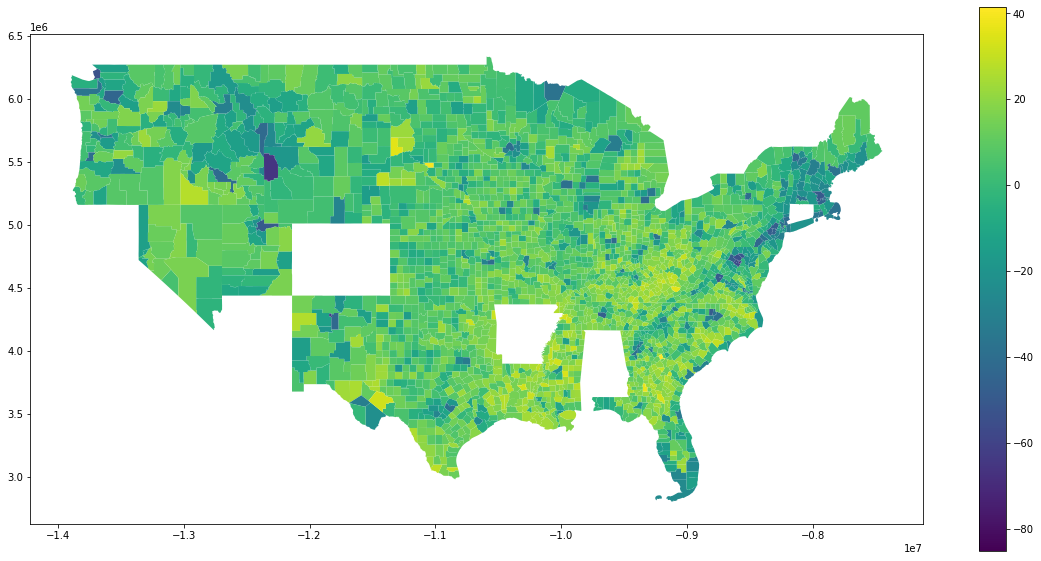

In [49]:
# plot the residuals
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('resid', legend=True, ax=ax)

In [50]:
# compute Moran's I on the residuals
m_resid = Moran(counties['resid'], w)
print(m_resid.I, m_resid.p_sim)

0.4393447930924223 0.001


In [51]:
# compute local Moran's I on the residuals and plot hot spots and cold spots
rm = Moran_Local(counties['resid'], w, transformation = "r", permutations = 99)

In [52]:
sig = rm.p_sim < 0.05
hotspot = sig * rm.q==1
coldspot = sig * rm.q==3

In [53]:
spot_h = ['n.sig.', 'hot spot']
label_h = [spot_h[i] for i in hotspot*1]

spot_c = ['n.sig.', 'cold spot']
label_c = [spot_c[i] for i in coldspot*1]

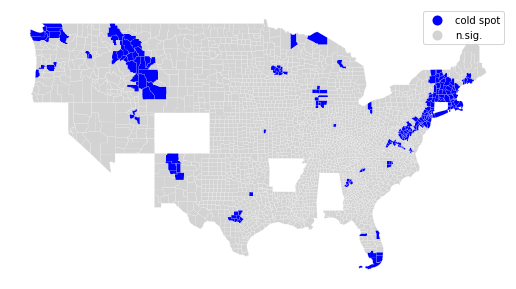

In [54]:
counties = counties
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
counties.assign(cl=label_c).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

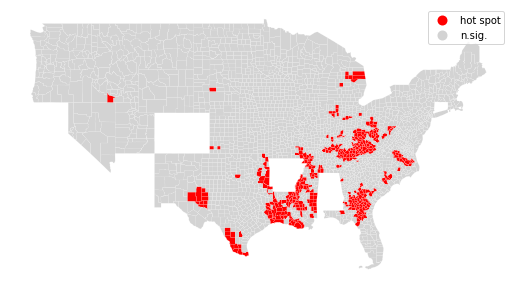

In [55]:
counties = counties
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
counties.assign(hl=label_h).plot(column='hl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [56]:
#The results doesn't look like sptially according to Moran's I.

<div class="alert alert-block alert-success">
       Exercise 4.2: Repeat exercise 4.1 but now regress education, SNAP, hispanic, and, insurance on obesity. How do the results compare? Is there still residual spatial autocorrelation? If so, now how do the hot spots and cold spots compare to those from the percent obesity dependent variable?
</div>

In [57]:
# regress education, SNAP, hispanic, and, insurance on obesity
feature_columns = ["Percentage"]
x = counties[feature_columns]
y_SNAP = counties['B22005B_002E']

model_2 = LinearRegression()
model_2.fit(x, y_SNAP)

print (model_2.intercept_)
print (model_2.coef_)

-0.024871751719687106
[0.0010603]


In [58]:
y_hispanic = counties['B03002_012E']

model_3 = LinearRegression()
model_3.fit(x, y_hispanic)

print (model_3.intercept_)
print (model_3.coef_)

0.22716646045306466
[-0.00421982]


In [59]:
y_insurance = counties['C27001G_007E']

model_4 = LinearRegression()
model_4.fit(x, y_insurance)

print (model_4.intercept_)
print (model_4.coef_)

0.0014393302153672537
[2.20603717e-05]


In [60]:
# extract residuals and plot
OLS_model2 = sm.OLS(x, y_SNAP).fit()
counties['resid_SNAP'] = OLS_model2.resid

OLS_model3 = sm.OLS(x, y_hispanic).fit()
counties['resid_hispanic'] = OLS_model3.resid

OLS_model4 = sm.OLS(x, y_insurance).fit()
counties['resid_insurance'] = OLS_model4.resid

In [61]:
# compute Moran's I on the residuals
m_resid_SNAP = Moran(counties['resid_SNAP'], w)
print(m_resid_SNAP.I, m_resid_SNAP.p_sim)

m_resid_hispanic = Moran(counties['resid_hispanic'], w)
print(m_resid_hispanic.I, m_resid_hispanic.p_sim)

m_resid_insurance = Moran(counties['resid_insurance'], w)
print(m_resid_insurance.I, m_resid_insurance.p_sim)

0.6462527214236414 0.001
0.7909352857374123 0.001
0.40628502863009447 0.001


In [62]:
# compute local Moran's I on the residuals and plot hot spots and cold spots
rm_SNAP = Moran_Local(counties['resid_SNAP'], w, transformation = "r", permutations = 99)
rm_hispanic = Moran_Local(counties['resid_hispanic'], w, transformation = "r", permutations = 99)
rm_insurance = Moran_Local(counties['resid_insurance'], w, transformation = "r", permutations = 99)

sig_SNAP = rm_SNAP.p_sim < 0.05
hotspot_SNAP = sig * rm_SNAP.q==1
coldspot_SNAP = sig * rm_SNAP.q==3

sig_hispanic = rm_hispanic.p_sim < 0.05
hotspot_hispanic = sig * rm_hispanic.q==1
coldspot_hispanic = sig * rm_hispanic.q==3

sig_insurance = rm_insurance.p_sim < 0.05
hotspot_insurance = sig * rm_insurance.q==1
coldspot_insurance = sig * rm_insurance.q==3

In [63]:
spot_h_SNAP = ['n.sig.', 'hot spot']
label_h_SNAP = [spot_h_SNAP[i] for i in hotspot_SNAP*1]

spot_c_SNAP = ['n.sig.', 'cold spot']
label_c_SNAP = [spot_c_SNAP[i] for i in coldspot_SNAP*1]


spot_h_hispanic = ['n.sig.', 'hot spot']
label_h_hispanic = [spot_h_hispanic[i] for i in hotspot_hispanic*1]

spot_c_hispanic = ['n.sig.', 'cold spot']
label_c_hispanic = [spot_c_hispanic[i] for i in coldspot_hispanic*1]


spot_h_insurance = ['n.sig.', 'hot spot']
label_h_insurance = [spot_h_insurance[i] for i in hotspot_insurance*1]

spot_c_insurance = ['n.sig.', 'cold spot']
label_c_insurance = [spot_c_insurance[i] for i in coldspot_insurance*1]

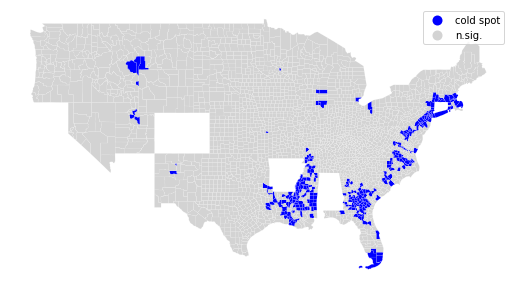

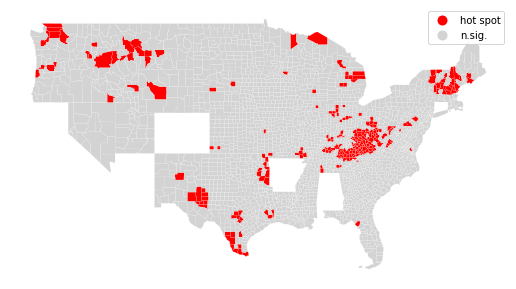

In [64]:
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
counties.assign(cl=label_c_SNAP).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

counties = counties
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
counties.assign(hl=label_h_SNAP).plot(column='hl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

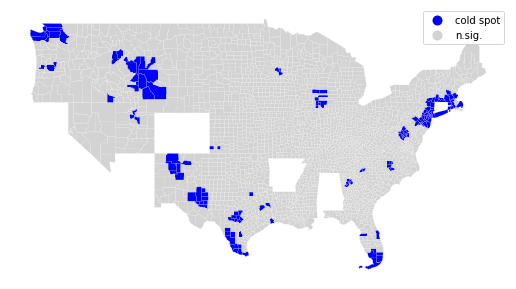

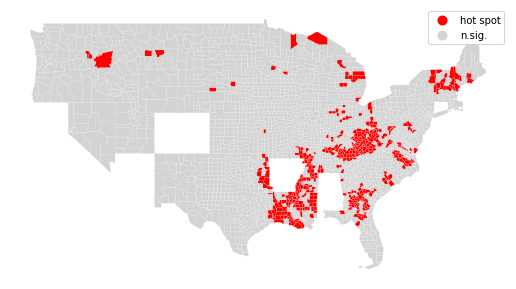

In [65]:
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
counties.assign(cl=label_c_hispanic).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
counties.assign(hl=label_h_hispanic).plot(column='hl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

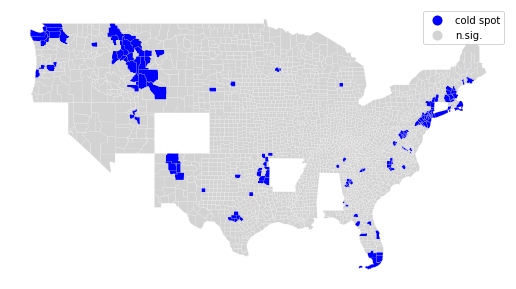

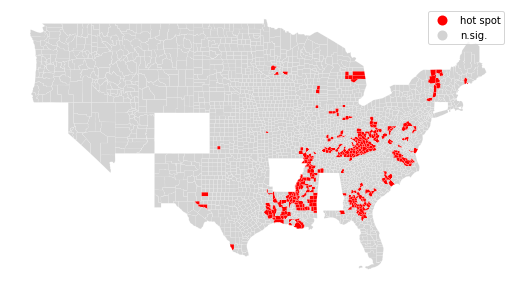

In [66]:
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
counties.assign(cl=label_c_insurance).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
counties.assign(hl=label_h_insurance).plot(column='hl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [67]:
counties.head()

,MTFCC,OID,GEOID,STATE,COUNTY,COUNTYNS,BASENAME,NAME,LSADC,FUNCSTAT,...,B22005B_002E,B03002_012E,C27001G_007E,B25026_001E,state,county,resid,resid_SNAP,resid_hispanic,resid_insurance
0,G4020,27556109873712,30015,30,015,01719619,Chouteau,Chouteau County,06,A,...,0.000000,0.021644,0.002269,5729,30,015,-2.486164,28.900000,26.677214,18.551273
1,G4020,27556119101045,31017,31,017,00835830,Brown,Brown County,06,A,...,0.000000,0.010431,0.002019,2972,31,017,11.610313,38.500000,37.428807,29.292858
2,G4020,27556136791559,47013,47,013,01639728,Campbell,Campbell County,06,A,...,0.000405,0.012257,0.001393,39488,47,013,18.320557,32.390021,31.441263,26.347862
3,G4020,27556177452845,37069,37,069,01008553,Franklin,Franklin County,06,A,...,0.031747,0.081023,0.001663,61328,37,069,9.292190,11.812386,27.779202,28.514857
4,G4020,27556165683114,24510,24,510,01702381,Baltimore,Baltimore city,25,F,...,0.087480,0.049497,0.001379,596742,24,510,-4.344731,-32.024718,29.816831,28.610217


<div class="alert alert-block alert-success">
       Exercise 4.3: Let's extract our variables from our dataframe to organize them as the endogenous dependent variable (y) vector and the exogenous explanatory variables (X) matrix. This is the typical format for regression tools in PySAL. We also want to center (mean = 0) and scale (var = 1) our variables. This is useful for OLS because it allows us to interpret the coefficient estimates in relation to each other (relative magnitudes). Otherwise the coefficient estimates may have vastly different magnitudes/scales (very small for large X and very large for small X) that cannot be compared to each other. This is also useful/necessary for MGWR because we want the bandwidth estimates to reflect variation in only the process (coefficients) and not the different magnitudes/scales of the data. Next, calibrate an OLS regression for all of our selected variables using PySAL's OLS functionality because it provides important diagnostics. Interpret the resulting coefficient estimates from most influential to least influential, direction of relationship (positive/negative) and statistical significance at the 95% confidence interval.
</div>

In [68]:
#reorganize data

names = ['education', 'snap', 'hispanic', 'insurance']
names = ['resid','resid_SNAP', 'resid_hispanic', 'resid_insurance']
codes = ['B16010_041E', 'B22005B_002E', 'B03002_012E', 'C27001G_007E']

y = counties[names].values.reshape((-1,1))
X = counties[codes]

In [69]:
#center and scale data

x = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean(axis=0)) / y.std(axis=0)

In [70]:
y

array([[-1.28462492],
       [ 0.54626028],
       [ 0.41659594],
       ...,
       [ 0.49959296],
       [-0.19366603],
       [-0.30634155]])

In [71]:
#calibrate OLS using PySAL

ols_results = spreg.OLS(x, y, w, spat_diag=True, name_x=names)
print(ols_results.summary)

Exception: all input data must be either numpy arrays or sparse csr matrices

In [ ]:
# interpret the resulting coefficient estimates by editing the list below

- most influential: pos/neg, sig?
- ...
- ...
- ...
- least influential: pos/neg, sig?

## Exercise 5: Global spatial regression (4 points)

<div class="alert alert-block alert-success">
               Exercise 5.1: Two popular (global) spatial regression specifications are the spatial lag model and the spatial error model. The spatial lag model incorporates an autoregressive process (spatial lag of y) directly into the estimator (not just as an additional variable). This specification is motivated by a process where the value at each location is directly dependent upon neighboring values (think house prices). In contrast, the spatial error model incorporates an autoregressive process in the error term to filter out the autocorrelation in the residuals (perhaps because we are missing an important variable). An important question is: which specification should we use? Sometimes theory may guide us (like house prices), but it is not always clear and so we can rely on diagnostic tests for spatial dependence. The Lagrange Multiplier provides evidence towards one specification or the other. Notice above in the OLS summary that Lagrange Multiplier (lag) = 262.027 and Lagrange Multiplier (error) = 282.079. Since 282.079 > 262.027 this provides evidence for the error model over the lag model. However, Lagrange Multiplier (SARMA) = 295.819 also suggests a combo lag/error model may be the most appropriate, though this outside the scope of this lab. Another important question is: how do the lag/error model results differ? To examine this, lets calibrate each model.
</div>

In [ ]:
#calibrate lag model

lag = spreg.ML_Lag(x, y, w, name_x=names)
print(lag.summary)

In [ ]:
#calibrate error model

error = spreg.ML_Error(xxx, xxx, xxx, name_x=names)
print(error.summary)

<div class="alert alert-block alert-success">
               Exercise 5.2: There are two primary differences between the lag/error model results. (1) How we interpret the autoregressive parameter: In the error model, the autoregressive parameter (lamba) does not have an additional interpretation and is therefore sometimes referred to as a 'nuisance' parameter. In contrast, the autoregressive parameter in the lag model (W_dep_var) also denotes what are called spillover effects. Spillover effects encapsulate the idea that each relationship in the model is no longer independent. That is, if you change a single explanatory variable value at one location, it not only affects the dependent variable at that location, but also the dependent variable at the neighboring locations. These are called indirect effects in comparison to the classic interpretation of coefficients as the direct effects. An example of this is demonstrated below where you can see some sizable differences in coefficient estimate magnitudes after accounting for the indirect (spillover) effects. (2) The danger in using OLS instead of the correct spatial regression. For the spatial lag model we typically expect that some of the coefficient estimates will be statistically different from those obtained through OLS, especially after Incorporating the spillover effects. In contrast, we do not expect this to be true in the spatial error model. For example, if you compute the 95% confidence intervals for the coefficient estimates from the spatial lag model, you might see that some do not overlap with those from the 95% confidence intervals for the OLS results. This is not true for the error model – we would not typically see that the 95% confidence intervals for the coefficient estimates from the spatial error model overlap with The 95% confidence intervals for the OLS results. Compute the 95% confidence intervals for the coefficient estimates from the three models (ols, lag, error). How many intervals overlap between the ols and lag models? How many intervals overlap between the ols and error models? Hint: can 95% confidence interval can be computed as (estimate - 1.96 \* stand_error, estimate + 1.96 \* stand_error).

In [ ]:
#direct and indirect effects from the lag model

b=lag.betas[:-1]
rho=lag.betas[-1]
btot=b/(float(1)-rho)
bind=btot-b

full_eff=pd.DataFrame(np.hstack([b,bind,btot]),index=['Constant']+names, columns=['Direct','Indirect','Total'])
full_eff

In [ ]:
# How many intervals overlap between the ols and lag models? 


In [ ]:
#How many intervals overlap between the ols and error models? 


<div class="alert alert-block alert-success">
               Exercise 5.3: Finally, create a map of the residuals from the lag model and the error model and also calculate the Moran's I values, and map the hot and cold spots from local Moran's I. Does there appear to be any residual spatial autocorrelation? Hint: the model residuals are the 'u' attribute in the lag and error models.

In [ ]:
# extract residuals and plot them for counties


In [ ]:
#Moran's I for the residuals from the lag model


In [ ]:
# hot and cold spots


In [ ]:
# extract residuals and plot them for counties


In [ ]:
#Moran's I for the residuals from the error model


In [ ]:
# hot and cold spots


## Exercise 6: Geographically weighted regression (4 points)

<div class="alert alert-block alert-success">
       Exercise 6.1: Even though the results above for the global spatial regression models suggested the use of an error model over a lag model, the analysis of the residual spatial autocorrelation suggests that further analysis might be necessary. It might be useful to consider different types of spatial weight matrices or perhaps to investigate spatial heterogeneity in the processes. This is where GWR/MGWR comes in. First we need to extract the coordinates for the centroids from the county geometries. After this is done, calibrate a GWR and MGWR model. How do the selected bandwidths differ between the two models? Is the GWR bandwidth larger or smaller than the MGWR bandwidths?
</div>

In [ ]:
# extract the coordinates for the centroids from the county geometries

counties['X'] = counties.apply(lambda row: row.geometry.centroid.coords[0][0], axis=1)
counties['Y'] = counties.apply(lambda row: row.geometry.centroid.coords[0][1], axis=1)
u = counties['X']
v = counties['Y']
coords = list(zip(u,v))

In [ ]:
#Calibrate GWR

gwr_selector = Sel_BW(xxx, xxx, xxx)
gwr_bw = gwr_selector.xxx
print(gwr_bw)
gwr_model = GWR(xxx, xxx, xxx, xxx)
gwr_results = gwr_model.xxx

In [ ]:
#Calibrate MGWR - this will take around 20 to 30 minutes...Feel free To take a break with some coffee or tea!

mgwr_selector = Sel_BW(xxx, xxx, xxx, xxx=True)
mgwr_bw = mgwr_selector.xxx
print(mgwr_bw)
mgwr_model = MGWR(xxx, xxx, xxx, mgwr_selector)
mgwr_results = mgwr_model.xxx

<div class="alert alert-block alert-success">
       Exercise 6.2: Once we have our results we can extract into a Dataframe for visualization. Noticed below that we are using the 'filter_tvals' method to identify statistically insignificant coefficient estimates using the GWR specific hypothesis testing correction for the 95% confidence interval. These are then added to the maps of the results as the great polygons to block out serious patterns. Describe the differences between the surfaces/maps of parameter estimates between GWR and MGWR for each of the explanatory variables.
</div>

In [ ]:
#Add GWR parameters to GeoDataframe
counties['gwr_intercept'] = gwr_results.params[:,0]
counties['gwr_edu'] = gwr_results.params[:,1]
counties['gwr_snap'] = gwr_results.params[:,2]
counties['gwr_hisp'] = gwr_results.params[:,3]
counties['gwr_ins'] = gwr_results.params[:,4]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

#Calibrate MGWR model

#Add MGWR parameters to GeoDataframe
counties['mgwr_intercept'] = mgwr_results.params[:,0]
counties['mgwr_edu'] = mgwr_results.params[:,1]
counties['mgwr_snap'] = mgwr_results.params[:,2]
counties['mgwr_hisp'] = mgwr_results.params[:,3]
counties['mgwr_ins'] = mgwr_results.params[:,4]

#Obtain t-vals filtered based on multiple testing correction
mgwr_filtered_t = mgwr_results.filter_tvals()

kwargs1 = {'edgecolor':'black', 'alpha':.65}
kwargs2 = {'edgecolor':'black'}

compare_surfaces(counties, 'gwr_intercept', 'mgwr_intercept', gwr_filtered_t[:,0],
        gwr_bw, mgwr_filtered_t[:,0], mgwr_bw[0], 'Intercept', kwargs1, kwargs2)

compare_surfaces(counties, 'gwr_edu', 'mgwr_edu', gwr_filtered_t[:,1], 
        gwr_bw, mgwr_filtered_t[:,1], mgwr_bw[1], 'Education', kwargs1, kwargs2)

compare_surfaces(counties, 'gwr_snap', 'mgwr_snap', gwr_filtered_t[:,2], 
        gwr_bw, mgwr_filtered_t[:,2], mgwr_bw[2], 'SNAP', kwargs1, kwargs2)

compare_surfaces(counties, 'gwr_hisp', 'mgwr_hisp', gwr_filtered_t[:,3],
        gwr_bw, mgwr_filtered_t[:,3], mgwr_bw[3], 'Hispanic', kwargs1, kwargs2)

compare_surfaces(counties, 'gwr_ins', 'mgwr_ins', gwr_filtered_t[:,4],
        gwr_bw, mgwr_filtered_t[:,4], mgwr_bw[4], 'Insurance', kwargs1, kwargs2)

In [ ]:
# describe the differences between the maps below

- Intercept:
- Education:
- SNAP:
- Hispanic:
- Insurance:

<div class="alert alert-block alert-success">
       Exercise 6.3: Now let's check the model fit based on the $R^2$ and Akaike Info Criterion (AIC). How does it compare for GWR and MGWR, as well as to the results for OLS and the lag and error models? What does this suggest?

In [ ]:
# model criterion comparison

<div class="alert alert-block alert-success">
               Exercise 6.4: Finally, create a map of the residuals from the MGWR model and also calculate the Moran's I values, and map the hot and cold spots from local Moran's I. Does there appear to be any residual spatial autocorrelation? Hint: the model residuals are the 'resid_response' attribute in MGWR model.

In [ ]:
# extract residuals and plot them for counties


In [ ]:
#Moran's I for the residuals from the lag model


In [ ]:
# hot and cold spots


<div class="alert alert-block alert-success">
               Final thoughts: Were there any patterns in the MGWR analysis that were not convincing? If so, please describe them below, along with any other final thoughts, questions, or comments. To conclude, I want to share the concept of *equifinality*. This is the principle whereby a given end state maybe reached by many potential means. In the context of spatial regression, this is important because it means that for a given spatial pattern, it could have been created by multiple different processes. For example, it could have been created by a spatial autoregressive process (house prices) that would that would be best captured by a spatial lag model or it could have been created by spatially heterogeneous processes that would be best captured by GWR/MGWR. In reality, we will never really know and so we need to use a combination of statistical tests, empirical evidence, and theory to guide our decision-making. It is also worth noting that it is also possible to have processes/models that combined aspects of dependence/heterogeneity (global vs local spatial effects), but these become complicated very quickly and bring us into the realms of advanced spatial econometrics and spatial statistics.

In [ ]:
# Final thoughts go here: